In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from numpy import linalg as LA

from scipy.signal import butter, lfilter, filtfilt
from scipy.signal import freqs

In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in Matplo

In [2]:
#16 QAM with gray code

Qam16Cnt = {
    "0000": (-3, -3),
    "0001": (-3, -1),
    "0011": (-3,  1),
    "0010": ( 3,  3),
    "0100": (-1, -3),
    '0101': (-1, -1),
    '0111': ( 1,  1),
    '0110': ( 1,  3),
    '1100': ( 1, -3),
    '1101': ( 1, -1),
    '1111': ( 1,  1),
    '1110': ( 1,  3),
    '1000': ( 3, -3),
    '1001': ( 3, -1),
    '1011': ( 3,  1),
    '1010': ( 3,  3),
}


In [3]:
def source(n, p):
    b = np.random.rand(1, n)
    b[b>0.5] = 1
    b[b<=0.5] = 0
    return b.flatten()


def bit_to_synb(b, cnt):
    b_str = "".join(str(int(e)) for e in b)
    synb = list()
    M = np.log2(len(cnt))
    for i in range(int(len(b)/M)):
        synb.append(cnt[b_str[4*i:4*i+4]])
    return synb

def SeperateIandQ(symb):
    symb_I, symb_Q = list(), list()
    for i in range(len(symb)):
        symb_I.append(symb[i][0])
        symb_Q.append(symb[i][1])
    return symb_I, symb_Q

In [4]:
b = source(1024, 0.5)
symb = bit_to_synb(b, Qam16Cnt)
#print(symb[0:10])
print(symb)
symb_I, symb_Q = SeperateIandQ(symb)
print(symb_I)

[(1, 1), (1, -3), (1, 3), (3, -3), (3, 3), (1, 1), (3, 3), (-1, -1), (3, -3), (3, 3), (1, 3), (-3, -3), (3, -3), (-3, 1), (1, 3), (-3, -3), (1, 3), (1, 1), (3, 1), (1, 3), (-3, -3), (-3, -3), (-3, 1), (-3, 1), (1, -1), (3, -1), (3, 3), (3, 3), (-1, -3), (3, 3), (1, 1), (-3, -1), (1, 1), (1, 1), (-1, -3), (3, -1), (-3, -1), (3, -3), (-1, -1), (1, -3), (3, 3), (-3, 1), (-3, 1), (3, 1), (1, 1), (1, 3), (-3, -3), (-3, -1), (1, 1), (-3, 1), (-1, -3), (1, -3), (1, -3), (3, 1), (3, -3), (3, 3), (-3, -1), (-3, -3), (3, 1), (3, -1), (1, 1), (3, -3), (-3, -1), (3, 3), (-1, -3), (3, 3), (3, 3), (-3, 1), (1, 3), (1, 3), (1, -1), (-1, -3), (-3, -1), (1, 3), (-1, -3), (3, 3), (1, 1), (3, 1), (3, 3), (3, 3), (-1, -3), (3, 1), (1, -1), (3, 3), (-3, -3), (3, 3), (1, -1), (1, -1), (1, 1), (1, 1), (3, 3), (1, 3), (3, 3), (1, 3), (3, 1), (1, -1), (3, -1), (3, 1), (3, 3), (3, 1), (1, 3), (1, 3), (-3, -1), (-1, -3), (1, -1), (1, 3), (3, 3), (1, 3), (-3, 1), (1, -3), (1, 3), (1, 3), (3, 3), (1, -3), (3, 3), 

In [5]:
def BasisGenerate(n, f_b, f_samp, T_duration, shift=1):
    sig_shift = np.linspace(0, shift*(n-1), n)
    ts = np.linspace(T_duration[0], T_duration[1], (T_duration[1]-T_duration[0])*f_samp)
    
    Ts, shift = np.meshgrid(sig_shift, ts)
    basis = np.sinc(2*np.pi*f_b*(Ts - shift))
    
    for i in range(basis.shape[1]):
        basis[:,i] = basis[:,i] / LA.norm(basis[:,i])
    
    
    return basis, ts

def Modulation(symbols, f_basis, f_samp, T_duration, shift):
    #basis, ts = BasisGenerate(len(symbols), 200, 1000, (-5, 10), 0.02)
    basis, ts = BasisGenerate(len(symbols), f_basis, f_samp, T_duration, shift)
    ret_basis = basis.copy()
    
    for i in range(len(symbols)):
        basis[:,i] = basis[:,i] * symbols[i] 
        
    return basis.dot(np.ones((basis.shape[1], 1))).flatten(), ret_basis, ts

def Transmiter(signal_I, signal_Q, fc, ts):
    signal_I = signal_I.flatten()
    signal_Q = signal_Q.flatten()
    carry_I = np.sqrt(2) * np.cos(2*np.pi*fc*ts)
    carry_Q = np.sqrt(2) * np.sin(2*np.pi*fc*ts)
    
    return signal_I*carry_I + signal_Q*carry_Q, carry_I, carry_Q

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def Seperator(signal, sig_carry, cutoff, f_sampling, order=6):
    #carry_I = np.sqrt(2) * np.cos(2*np.pi*f_carry*ts)
    #carry_Q = np.sqrt(2) * np.sin(2*np.pi*f_carry*ts)
    
    (carry_I, carry_Q) = sig_carry
    re_signal_I = signal * carry_I
    re_signal_Q = signal * carry_Q
    re_signal_I_filter = butter_lowpass_filter(re_signal_I, cutoff, f_sampling, order)
    re_signal_Q_filter = butter_lowpass_filter(re_signal_Q, cutoff, f_sampling, order)

    return re_signal_I_filter, re_signal_Q_filter
    
def DemodulationHelper(signal, basis):
    signal = signal.flatten()
    est_symbols = list()
    for i in range(basis.shape[1]):
        est_symbols.append(np.sum(signal * basis[:,i]))
    
    return est_symbols

def Demoudulation(signal, f_carry, cutoff, f_sampling):
    re_signal_I, re_signal_Q = Seperator(signal, f_carry, cutoff, f_sampling, order=6)
    est_symbols_I = DemodulationHelper(re_signal_I, basis)
    est_symbols_Q = DemodulationHelper(re_signal_Q, basis)
    
    return est_symbols_I, est_symbols_Q, re_signal_I, re_signal_Q    

In [6]:
def distance(s1, s2):
    x1, y1 = s1
    x2, y2 = s2
    return LA.norm(np.array([x1-x2, y1-y2]))

def MLDetector(symbol, cnt):
    est_symb = ""
    min_dist = 1000
    for _, canst in cnt.items():
        dist = distance(symbol, canst)
        if dist < min_dist: 
            min_dist = dist
            est_symb = canst
    return est_symb

def SymbolsToBits(symbols, cnt):
    inv_cnt = {v: k for k, v in cnt.items()}
    est_str_binary_source = ""
    for symb in symbols:
        est_str_binary_source += inv_cnt[symb]
    
    est_binary_source = list()
    for b in est_str_binary_source:
        if (b == '0'): est_binary_source.append(0)
        else: est_binary_source.append(1)
    return est_binary_source

def Detector(symbol_I, symbol_Q, cnt):
    est_symbol_list = list()
    for i in range(len(symbol_I)):
        est = MLDetector((symbol_I[i], symbol_Q[i]), cnt)
        est_symbol_list.append(est)
        
    est_binary_source = SymbolsToBits(est_symbol_list, cnt)
    return est_binary_source

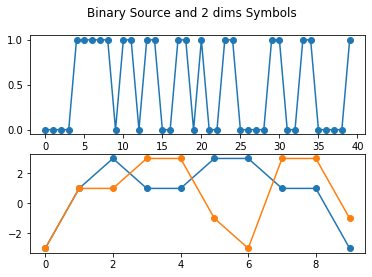

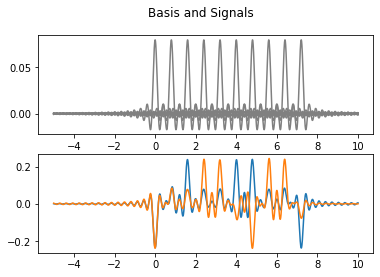

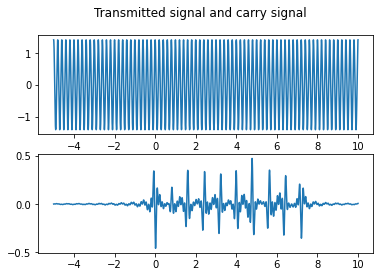

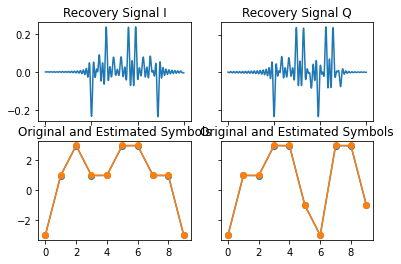

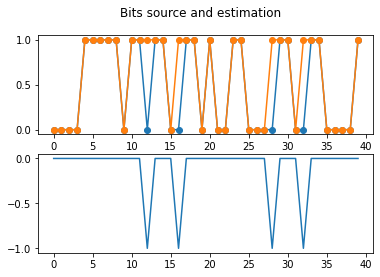

In [7]:
#Generate Source
binary_source = source(4*10, 0.5)
symb = bit_to_synb(binary_source, Qam16Cnt)
symb_I, symb_Q = SeperateIandQ(symb)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Binary Source and 2 dims Symbols')
ax1.plot(binary_source, 'o-')
ax2.plot(symb_I,  'o-')
ax2.plot(symb_Q,  'o-')
plt.show()

#Modulation
f_basis = 1 #Hz
shift = 0.8 #sec
f_sampling = 1000 #Hz
f_carry = 5 #Hz
time_duration = (-5, 10) #time

signal_I, basis, ts = Modulation(symb_I, f_basis, f_sampling, time_duration, shift)
signal_Q,     _,  _ = Modulation(symb_Q, f_basis, f_sampling, time_duration, shift)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Basis and Signals')
ax1.plot(ts, basis, 'gray')
ax2.plot(ts, signal_I)
ax2.plot(ts, signal_Q)
plt.show()

#Transmiter
tr_signal, carry_I, carry_Q = Transmiter(signal_I, signal_Q, f_carry, ts)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Transmitted signal and carry signal')
ax1.plot(ts, carry_I)
ax2.plot(ts, tr_signal)
plt.show()

#Demodulation
cutoff = 4
est_symbols_I, est_symbols_Q, re_signal_I, re_signal_Q = Demoudulation(tr_signal, (carry_I, carry_Q), cutoff, f_sampling)
error_I = np.array(symb_I) - np.array(est_symbols_I)
error_Q = np.array(symb_Q) - np.array(est_symbols_Q)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(ts, re_signal_I)
axs[0, 0].set_title('Recovery Signal I')
axs[0, 1].plot(ts, re_signal_Q)
axs[0, 1].set_title('Recovery Signal Q')
axs[1, 0].plot(est_symbols_I, 'o-')
axs[1, 0].plot(symb_I, 'o-')
axs[1, 0].set_title('Original and Estimated Symbols')
axs[1, 1].plot(est_symbols_Q, 'o-')
axs[1, 1].plot(symb_Q, 'o-')
axs[1, 1].set_title('Original and Estimated Symbols')
for ax in axs.flat:
    ax.label_outer()

est_binary_source = Detector(est_symbols_I, est_symbols_Q, Qam16Cnt)
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Bits source and estimation')
ax1.plot(binary_source, 'o-')
ax1.plot(est_binary_source, 'o-')
ax2.plot(np.array(binary_source) - np.array(est_binary_source))
plt.show()